In [2]:
# Use with NHL_Model_Data_Transform_v5.py
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt

rng = 69

In [3]:
df = pd.read_csv(r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Transformed.csv")
#df = pd.read_csv(r"C:\Users\zanec\OneDrive\Documents\Python\NHL_data\NHL_Data_Transformed_PCA - Test v1.csv")

In [4]:
# df.info()

In [5]:
df = df.drop(columns=['team_Home','team_Away','gameId','home_or_away_Home','home_or_away_Away','win_or_lose_Away'])

In [6]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

In [7]:
# Heatmap to visualize correlations
corr_matrix = df.corr(numeric_only=True)
# sns.heatmap(corr_matrix, cmap="PiYG")

In [8]:
corr_matrix['win_or_lose_Home'].sort_values(ascending=False)

win_or_lose_Home             1.000000
seasonPointsPerGame_Home     0.299766
fenwickPercentageAvg_Home    0.163282
goalDiffAvg_Home             0.119460
pointsFromGameAvg_Home       0.113631
hitsDiffAvg_Away             0.080313
reboundsForAvg_Home          0.059237
penaltiesAgainstTotal        0.031212
penaltiesForTotal           -0.019398
hitsDiffAvg_Home            -0.043300
reboundsForAvg_Away         -0.059421
pointsFromGameAvg_Away      -0.117607
goalDiffAvg_Away            -0.118270
fenwickPercentageAvg_Away   -0.172017
seasonPointsPerGame_Away    -0.290752
Name: win_or_lose_Home, dtype: float64

In [9]:
# Visualize distributions of attributes
# from pandas.plotting import scatter_matrix

# attributes = ['fenwickPercentageAvg_Home','goalDiffAvg_Home','seasonPointsPerGame_Home','seasonPointsPerGame_Away']
# scatter_matrix(df[attributes], figsize=(12,8));

In [10]:
# These are tentative just to test

df_Final = df
# df_Final = df.drop(columns=['corsiPercentageAvg_Away','penaltiesAgainstTotal','shotsOnGoalDiffAvg_Away'])

In [11]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data
train_set, test_set = train_test_split(df_Final, test_size=0.2, random_state=rng)

nhl = train_set.drop('win_or_lose_Home', axis=1)
nhl_labels = train_set['win_or_lose_Home'].copy()

X_train = train_set.drop('win_or_lose_Home', axis=1)
Y_train = train_set['win_or_lose_Home'].copy()
X_test = test_set.drop('win_or_lose_Home', axis=1)
Y_test = test_set['win_or_lose_Home'].copy()


df_Final = df_Final.drop('win_or_lose_Home', axis=1)

In [12]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_prepared= num_pipeline.fit_transform(X_train)
X_test_prepared= num_pipeline.fit_transform(X_test)


In [13]:
# Fine Tune the hyperparameters of RandomForest model
# from sklearn.model_selection import GridSearchCV

# param_grid = [{'n_estimators' : [100,500,1000], 'max_leaf_nodes': [10,16,25,50], 'n_jobs' : [-1]},
#               {'bootstrap': [False], 'n_estimators' : [100,500,1000], 'max_leaf_nodes': [10,16,25,50], 'n_jobs' : [-1]},]

# rnd_clf_test = RandomForestClassifier()

# grid_search = GridSearchCV(rnd_clf_test, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# grid_search.fit(nhl_prepared,nhl_labels)

# grid_search.best_params_

In [14]:
# cvres = grid_search.cv_results_
# results = []
# for mean_scores, params in zip(cvres["mean_test_score"], cvres["params"]):
#     results.append([np.sqrt(-mean_scores),params])

# results2 = sorted(results, key=lambda x: x[0])
# print(*results2, sep = '\n')

In [15]:
# Search for number of dimensions needed to preserve 95% of variance

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_prepared)
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_feature_PCA = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components = num_feature_PCA)
pca.fit_transform(X_train_prepared)
pca.explained_variance_ratio_



array([0.22591297, 0.19292614, 0.12300843, 0.08941453, 0.07941566,
       0.06279289, 0.05664563, 0.04323525, 0.03690067, 0.02802503,
       0.02557545])

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

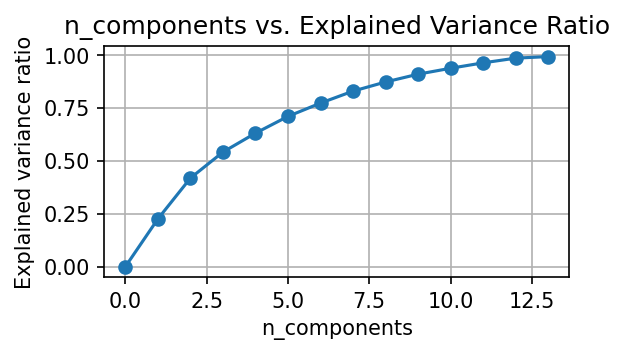

In [16]:
# Visualize variance sum with component #s
import numpy as np
nums = np.arange(df_Final.shape[1])

var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_train_prepared)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

import matplotlib.pyplot as plt

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [17]:
features_PCA = []
for i in range (1, num_feature_PCA+1):
    features_PCA.append(f'PCA_{i}')

pca = PCA(n_components = num_feature_PCA)
X_train_prepared_PCA = pca.fit_transform(X_train_prepared)
#print(pd.DataFrame(pca.components_,columns=df_Final.columns[0:X_train_prepared.shape[1]+1],index = [features_PCA]))

features_PCA = []
for i in range (1, num_feature_PCA+1):
    features_PCA.append(f'PCA_{i}')

pca = PCA(n_components = num_feature_PCA)
X_test_prepared_PCA = pca.fit_transform(X_test_prepared)

In [18]:
# Try using a Random Forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, n_jobs=-1, random_state=rng)

rnd_clf.fit(X_train_prepared_PCA, Y_train)

RandomForestClassifier(max_leaf_nodes=50, n_estimators=500, n_jobs=-1,
                       random_state=69)

In [19]:
from sklearn.model_selection import cross_val_predict
Y_train_pred = cross_val_predict(rnd_clf, X_train_prepared_PCA, Y_train, cv=5)

from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_train_pred)
# [Predict Loss - Actual Loss  |  Predict Win - Actual Loss]
# [Predict Loss - Actual Win   |  Predict Win - Actual Win]

array([[ 880,  603],
       [ 440, 1293]], dtype=int64)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('When claiming is a win, correct % is ', precision_score(Y_train, Y_train_pred))
print('Detected % of wins' ,recall_score(Y_train, Y_train_pred))
print('F1 score is ', f1_score(Y_train, Y_train_pred))
print('Training Accuracy score is ', accuracy_score(Y_train, Y_train_pred))


When claiming is a win, correct % is  0.6819620253164557
Detected % of wins 0.7461050201961916
F1 score is  0.712593000826674
Training Accuracy score is  0.6756840796019901


In [28]:
# Use Test Data
Y_pred = rnd_clf.predict(X_test_prepared_PCA)
print(accuracy_score(Y_test, Y_pred))

0.9192546583850931


In [ ]:
# Use this to see importance of each feature in the Random Forest
# Take colmumn names from Final DataFrame, need to skip the label though

for name, score in zip(features_PCA,rnd_clf.feature_importances_):
    print(name,round(score*100,2))

In [ ]:
import pandas as pd

forest_importances = pd.Series(rnd_clf.feature_importances_, index=features_PCA)
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# # High Cardinality (although not the case here) can caues the built in feature_importance to be innacurate
# # This method takes longer but is more accurate in those situations

# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rnd_clf, nhl_prepared_PCA, nhl_labels, n_repeats=10, random_state=rng, n_jobs=2
# )

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [ ]:
df_Predict = pd.read_csv(r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Predict.csv")
#df_Predict = pd.read_csv(r"C:\Users\zanec\OneDrive\Documents\Python\NHL_data\NHL_Data_Predict.csv")

In [ ]:
X_real_predict = df_Predict.iloc[:,2:]

X_real_predict_PCA = pca.transform(X_real_predict)


np.array((df_Predict.iloc[:,1].values,rnd_clf.predict(X_real_predict_PCA))).T